In [1]:
%config Completer.use_jedi = False
%matplotlib inline

import os
import sys
import pytz
from datetime import datetime
import geopandas as gpd
from copy import copy, deepcopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from glob import glob
from shapely.geometry import Point, Polygon
from collections import Counter
from dask.distributed import Client
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import copy
from dask import dataframe as dd
from haversine import haversine

import mobilkit

sns.set_context("notebook", font_scale=1.5)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Example analysis of displacement

We will perform the following analysis:
- limit ourselves to August the 6th 2017 to November the 25th (included) for analysis (77 days);
- keep only users with at least 10pings per day in at least 50% of their active days (and with at least 20 active days);
- also we limit ourselves to users seen for the first time before September the 10th;
- assign the original home area with all the events between the firs day and September the 10th (included);
- compute the home for the rest of the days with a 4-days window and compute the fraction of displaced people per area;
- we also show how to aggregate to a wider tesselation (e.g., municipalities) to have a better statistics with respect to the smaller manzanas.


Launch worker and scheduler if working on localhost with:
```
dask-worker 127.0.0.1:8786 --nprocs -1 &
dask-scheduler
```
If you get an error with `Popen` in `dask-worker`, add the option `--preload-nanny multiprocessing.popen_spawn_posix` to the first command.

In [9]:
client = Client(address="127.0.0.1:8786")
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 33.29 GB


## Reload a previously tessellated dataset

First we define the schema, then we import the data.

It is important to use the expected column names for the relevant variables (read `mobilkit.sparkTypes` for info):
- `uid` for the users id;
- `tile_ID` for the aread id;
- `lat` and `lng` for latitude and longitude;
- `UTC` for the unix time stamp;
- `datetime` for the datetime column (this will be created when using load);

In [2]:
# Import needed stuff
files_pattern = "/data/dataTiled/part-00*.csv.gz"

mySchema = [
    ("UTC", int),
    ("uid", str),
    ("OS", float),
    ("lat", float),
    ("lng", float),
    ("acc", float),
    ("tz", float),
    ("tile_ID", int),
]

df_zones_reloaded = mobilkit.loader.load_raw_files(pattern=files_pattern,
            timezone="America/Mexico_City",
            start_date="2017-08-01", stop_date="2017-11-25",
            minAcc=300, version="csv", sep=",", file_schema=mySchema)

## Filter users

We compute the users stats. Then we show the results and decide which users to keep depending on their statistics. In particular we can filter users by their total number of pings and/or active days and by their fraction of days with at least $p$ pings (aka super-users).

In [12]:
# We first compute the stats and then we import them in pandas to better show the features
# Since we will use it many times and it won't be huge we also cache it for convenience
users_stats_df = mobilkit.stats.userStats(df_zones_reloaded).persist()

In [13]:
# We save this dataset to speed up following analysis
mobilkit.loader.persistDF(users_stats_df, "../data/users_stats_displacement",
                          out_format="parquet")

In [14]:
# ... and reload it later
users_stats_df = mobilkit.loader.reloadDF("../data/users_stats_displacement",
                                            in_format="parquet")

In [15]:
# Port to pandas for plotting...
users_stats_df_pd = users_stats_df.compute()

In [16]:
# Plot the 2d histogram with the pandas dataframe
# Plot not shown so as not to disclose original dataset statistics
mobilkit.stats.plotUsersHist(users_stats_df_pd, min_pings=400, min_days=20)

In [17]:
# Compute the fraction columns
users_stats_df_pd = mobilkit.stats.computeSurvivalFracs(users_stats_df_pd)

In [18]:
users_stats_df_pd.shape

(289555, 17)

In [19]:
# Plot the survival fraction per days
# Plot not shown so as not to disclose original dataset statistics
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax = mobilkit.stats.plotSurvivalDays(users_stats_df_pd, min_days=20, ax=ax)
ax.set_ylim(1e-2,1.)

plt.tight_layout()
plt.savefig("../figures/users_survival_displacement.pdf", bbox_inchex="tight")

In [20]:
# Plot the survival fraction per days
# Plot not shown so as not to disclose original dataset statistics
ax = mobilkit.stats.plotSurvivalFrac(users_stats_df_pd, min_frac=.7)
ax.set_ylim(1e-2,1.)

## Filter users

We now keep the pings of the users with at least 20 active days above the 20 pings threshold and with at least 30 active days. We also want users that have been see before September the fifth to be valid.

In [21]:
valid_users = set(users_stats_df_pd[
                    (users_stats_df_pd["daysActive"] >= 30)
                    & (users_stats_df_pd["days_above_020"] >= 20)
                    & (users_stats_df_pd["min_day"] <= datetime(2017,9,5))
                ]["uid"].values)
len(valid_users), len(users_stats_df_pd)

(9559, 289555)

In [22]:
df_filtered = mobilkit.stats.filterUsersFromSet(df_zones_reloaded, valid_users)

## Compute home and work location

Here we use the default parameters but see the functions' help for details.

Specifically, we first enrich the dataset with the information on the pings belonging to home or work hours.

Then we will keep only the pings during night (to see how to filter dataframe on the go) and persist the dataset.

---
**NOTE**

When determining the home location of a user, please consider that some data providers, like _Cuebiq_, obfuscate/obscure/alter the coordinates of the points falling near the user's home location in order to preserve privacy.

This means that you cannot locate the precise home of a user with a spatial resolution higher than the one used to obfuscate these data. If you are interested in the census area (or geohash) of the user's home alone and you are using a spatial tessellation with a spatial resolution wider than or equal to the one used to obfuscate the data, then this is of no concern.

However, tasks such as stop-detection or POI visit rate computation may be affected by the noise added to data in the user's home location area. Please check if your data has such noise added and choose the spatial tessellation according to your use case.

---

In [1]:
# Add the home/work columns
df_hw = mobilkit.stats.userHomeWork(df_filtered)

In [25]:
# Keep only the night pings with dask notation
df_hw_night = df_hw[df_hw["isHome"]]

df_hw_night.repartition(npartitions=1000).to_parquet("/data/dati_hflb_mex_sep_oct_night_pings")

In [27]:
df_hw_night = dd.read_parquet("/data/data_hflb_mex_sep_oct_night_pings")    

## Home area detection

We now assess the initial home of an individual in the first month of observation.

We then compute, for all the 4-days windows, the area where he spent the most of its time during nightime.

In [29]:
# The parameters of the home location in window function
df_hw_cached = df_hw_night.persist()
initial_days_home = 31
home_days_window = 4
start_date=None

In [31]:
init_df_joined_pd = mobilkit.temporal.homeLocationWindow(df_hw_cached,
                    initial_days_home=initial_days_home,
                    home_days_window=home_days_window,
                    start_date=None, stop_date=None)

Doing window 01 / 04
Doing window 02 / 04
Doing window 03 / 04
Doing window 04 / 04


In [ ]:
# We now have for ech user and time window (with its initial date) the location
# where he supposedly spent the night and how many pings are recorded there
# Table-preview not shown so as not to disclose original dataset statistics
init_df_joined_pd.head(2)

We compute all the arrays and figures needed for the plots (see function's help for details).

The importnt thing is to set the minimum number of recorded pings for a night to be statistical valid. Decreasing (increasing) this value we have more (less) noise in the measure but more (less) users to keep. A good balance seems to be around 5-10 pings.

In [33]:
minimum_pings_per_night = 5

pivoted, prima_zona,\
    heaps, count_users_per_area = mobilkit.temporal.computeDisplacementFigures(
        init_df_joined_pd, minimum_pings_per_night=minimum_pings_per_night,
)

In [34]:
dates_sorted = np.array(sorted(pivoted.columns))

In [35]:
# Compute dynamical home location 
df_displacement = mobilkit.temporal.homeLocationWindow(df_hw,
                    initial_days_home=30, home_days_window=4,
                    start_date=datetime(2017,8,1), stop_date=datetime(2017,11,30))

Doing window 01 / 04
Doing window 02 / 04
Doing window 03 / 04
Doing window 04 / 04


In [37]:
gdf = gpd.read_file("data/sample_shape/mexico_selection_epicentre.shp")

/home/ubi/Sandbox/mobilkit_dask/mobilkit/temporal.py:796: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["distance_epic"] = gdf.geometry.centroid.apply(lambda p:


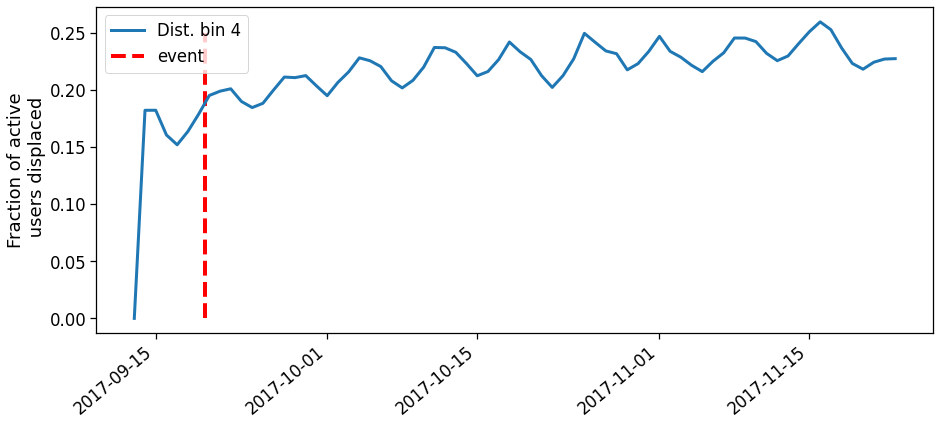

In [38]:
# Compute displacement figures
result = mobilkit.temporal.computeDisplacementFigures(df_displacement, minimum_pings_per_night=10)

# Assess displacement based on distance from epicenter
fig, gdf_enriched = mobilkit.temporal.plotDisplacement(count_users_per_area, pivoted,
                                   gdf,
                                   epicenter=[18.584,98.399],
                                   on="distance",
                                   bins=5)

### Reload the geodataframe

In [41]:
gdf = gpd.read_file("../data/sample_shape/mexico_selection_epicentre.shp")

In [42]:
# Distance from epicenter
epicenter_lat_lon = (18.579206,-98.399126)

In [ ]:
# Plot the number of users with the first home in area
# Plot not shown so as not to disclose original dataset statistics
count_first_home = Counter(prima_zona.values())

gdf["first_home_users"] = gdf["tile_ID"].apply(
    lambda v: count_first_home[v] if v in count_first_home else None)

fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.set_aspect("equal")
gdf[~gdf["first_home_users"].isna()].plot("first_home_users", edgecolor="none", legend=True,
                                          vmin=0, vmax=10, ax=ax)

gdf.plot(color="none", edgecolor="k", ax=ax, lw=.2, alpha=.5)

ax.plot(epicenter_lat_lon[1], epicenter_lat_lon[0],
               "or", ms=20, alpha=.8)

plt.tight_layout()
plt.savefig("figures/num_users_first_home.png",
            bbox_inchex="tight", dpi=160)

## See the displacement in two separate areas

By selecting the areas within two given rectangles.

In [46]:
# Around the epicenter
zone_earth = mobilkit.spatial.selectAreasFromBounds(gdf,
                    min_lon=-98.69, max_lat=18.93, max_lon=-97.880, min_lat=18.15)

# Far away in Mexico City
zone_mexc = mobilkit.spatial.selectAreasFromBounds(gdf,
                    min_lon=-99.414, max_lat=19.565, max_lon=-98.729, min_lat=19.178)

<ipython-input-47-8569b7aedcec>:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inchex" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/close_far_displacement.pdf", bbox_inchex="tight")


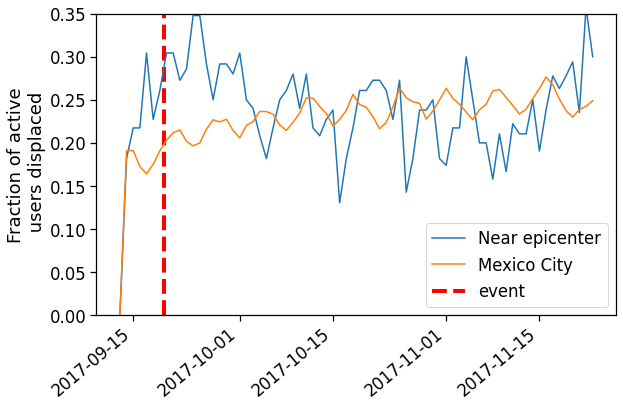

In [47]:
# Stack the arrays of displaced and active users
# and compute their ratio for the two areas
fig, ax = plt.subplots(1,1,figsize=(9,6))

tmp_arra_disp = np.vstack([count_users_per_area[a]["displaced"]
                          for a in zone_earth if a in count_users_per_area])
tmp_arra_act = np.vstack([count_users_per_area[a]["active"]
                          for a in zone_earth if a in count_users_per_area])
plt.plot(dates_sorted, tmp_arra_disp.sum(axis=0)
         / np.clip(tmp_arra_act.sum(axis=0), a_min=1., a_max=None),
         label="Near epicenter")

tmp_arra_disp = np.vstack([count_users_per_area[a]["displaced"]
                          for a in zone_mexc if a in count_users_per_area])
tmp_arra_act = np.vstack([count_users_per_area[a]["active"]
                          for a in zone_mexc if a in count_users_per_area])
plt.plot(dates_sorted, tmp_arra_disp.sum(axis=0)
         / np.clip(tmp_arra_act.sum(axis=0), a_min=1., a_max=None),
        label="Mexico City")

plt.vlines(datetime(2017,9,19,13,14), 0, .35, lw=4, linestyles="--", color="r",
          label="event")

plt.ylim(0, .35)

plt.xticks(rotation=40, ha="right")
plt.ylabel("Fraction of active\n users displaced")
plt.legend();

plt.tight_layout()
plt.savefig("figures/close_far_displacement.pdf", bbox_inchex="tight")

## Try to see displacement as a distance from epicenter

Now we consider all the areas and bin them by their distance from epicenter.

In [49]:
# Compute the distance of each area's centroid from epicenter
gdf["distance_epic"] = gdf.geometry.centroid.apply(lambda p: haversine(epicenter_lat_lon,
                                                    (p.xy[1][0], p.xy[0][0]) ))

<ipython-input-49-7b0397cb3185>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["distance_epic"] = gdf.geometry.centroid.apply(lambda p: haversine(epicenter_lat_lon,


In [50]:
# Bin areas depending on their distance: choose to use log or
# linear spaced bins (the latter works better)
if True:
    distance_bins = np.linspace(0, max(gdf["distance_epic"])+1, 6)
else:
    distance_bins = np.logspace(np.log2(max(1, min(gdf["distance_epic"])-1)),
                                np.log2(max(gdf["distance_epic"])+1), 5, base=2)


gdf["distance_bin"] = gdf["distance_epic"].apply(lambda v: np.argmax(distance_bins>=v)-1)

In [51]:
gdf["distance_bin"].value_counts()

2    4906
3    3139
1    2450
4     564
0     369
Name: distance_bin, dtype: int64

<ipython-input-52-c613520c9ca1>:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inchex" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/areas_bins_displacement.png",


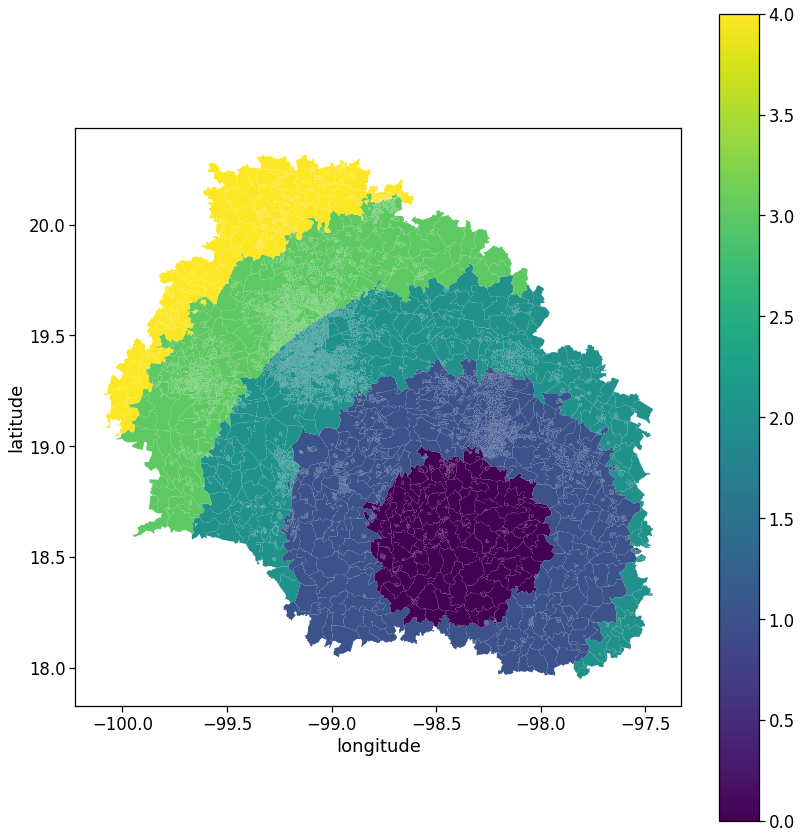

In [52]:
# Plot the bins
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.set_aspect("equal")

gdf.plot("distance_bin", legend=True, ax=ax)

plt.xlabel("longitude")
plt.ylabel("latitude")

plt.tight_layout()
plt.savefig("figures/areas_bins_displacement.png",
            bbox_inchex="tight", dpi=160)

<ipython-input-53-f233e9f7adca>:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inchex" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/areas_bins_displacement_curves.pdf", bbox_inchex="tight")


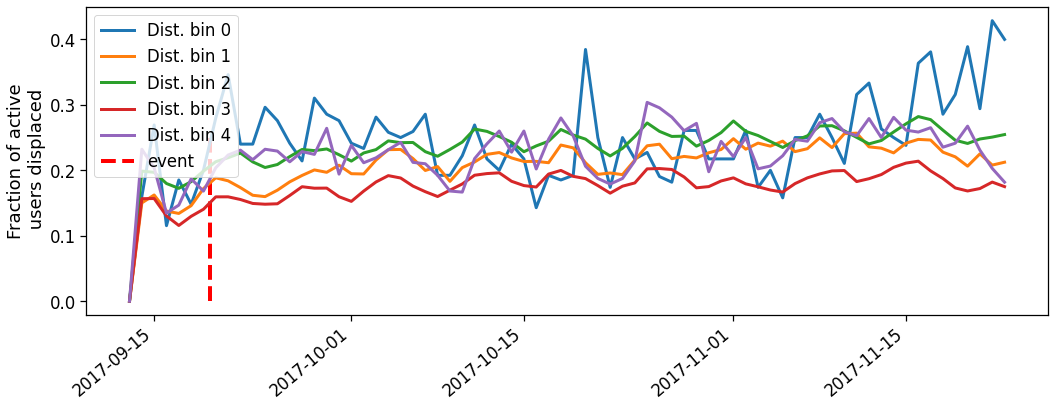

In [53]:
# For each bin's areas plot the displacement rate
fig, ax = plt.subplots(1,1,figsize=(15,6))

for dist_bin in range(len(distance_bins)):
    tmp_areas = set(gdf[gdf["distance_bin"]==dist_bin]["tile_ID"].values)
    tmp_areas = tmp_areas.intersection(count_users_per_area.keys())
    if len(tmp_areas) == 0:
        continue
        
    tmp_arra_disp = np.vstack([count_users_per_area[a]["displaced"] for a in tmp_areas])
    tmp_arra_act = np.vstack([count_users_per_area[a]["active"] for a in tmp_areas])
    plt.plot(dates_sorted, tmp_arra_disp.sum(axis=0)
             / np.clip(tmp_arra_act.sum(axis=0), a_min=1., a_max=None),
             label="Dist. bin %d"%dist_bin, lw=3)
    
plt.vlines(datetime(2017,9,19,13,14), 0, .25, lw=4, linestyles="--", color="r",
          label="event")

plt.xticks(rotation=40, ha="right")
plt.ylabel("Fraction of active\n users displaced")
plt.legend();

plt.tight_layout()
plt.savefig("figures/areas_bins_displacement_curves.pdf", bbox_inchex="tight")

In [ ]:
# For each bin's areas plot the number of active users
# Plot not shown so as not to disclose original dataset statistics
fig, ax = plt.subplots(1,1,figsize=(15,6))

for dist_bin in range(len(distance_bins)):
    tmp_areas = set(gdf[gdf["distance_bin"]==dist_bin]["tile_ID"].values)
    tmp_areas = tmp_areas.intersection(count_users_per_area.keys())
    if len(tmp_areas) == 0:
        continue
    tmp_arra_act = np.vstack([count_users_per_area[a]["active"] for a in tmp_areas])
    plt.semilogy(dates_sorted, tmp_arra_act.sum(axis=0),
             label="Dist. bin %d"%dist_bin, lw=3)
    
plt.vlines(datetime(2017,9,19,13,14), 0, .25, lw=4, linestyles="--", color="r",
          label="event")

plt.xticks(rotation=40, ha="right")
plt.ylabel("Number of active users")
plt.legend();

plt.tight_layout()
plt.savefig("figures/areas_bins_displacement_active_users.pdf", bbox_inchex="tight")

## Aggregate per municipality or locality

Here we aggregate the above analysis by putting together all the users that live in an area using their municipality or localiy entities.

We concat `CVE_ENT` and `CVE_MUN` to have a unique code for each municipality.

Otherwise, for locality, we use `CVEGEO` as a unique code for rural areas while we combine `CVE_ENT` + `CVE_MUN` + `CVE_LOC` for urban ones.

In [55]:
# Use municipality
gdf["UNIQUE_MUN"] = gdf["CVE_ENT"] + gdf["CVE_MUN"]

# Use locality code
valori = []
for _, r in gdf.iterrows():
    if r["CVEGEO"] is None:
        # Urban area
        valori.append(r["CVE_ENT"] + r["CVE_MUN"] + r["CVE_LOC"])
    else:
        # Rural, use its CVEGEO
        valori.append(r["CVEGEO"])
gdf["UNIQUE_LOC"] = valori
    
gdf.head(3)

,CVE_ENT,CVE_LOC,CVE_MUN,CVE_AGEB,CVEGEO,layer,path,ZONE_IDX,tile_ID,geometry,first_home_users,case,distance_epic,distance_bin,UNIQUE_MUN,UNIQUE_LOC
0,12,0039,055,0730,None,12a,/home/ubi/Downloads/mexico_bounds/download-map...,0,0,"POLYGON ((-99.54281 18.60610, -99.54198 18.606...",NaN,NaN,120.519220,2,12055,120550039
1,12,0001,049,0057,None,12a,/home/ubi/Downloads/mexico_bounds/download-map...,1,1,"POLYGON ((-99.67015 18.74569, -99.66967 18.744...",NaN,NaN,135.263500,3,12049,120490001
2,12,0001,049,0061,None,12a,/home/ubi/Downloads/mexico_bounds/download-map...,2,2,"POLYGON ((-99.67166 18.74997, -99.67122 18.748...",NaN,NaN,135.400304,3,12049,120490001


In [56]:
# Now dissolve the shapefile depending on these codes
gdf_mun = gdf.dissolve("UNIQUE_MUN")
gdf_loc = gdf.dissolve("UNIQUE_LOC")

In [59]:
gdf_mun.head(1)

,geometry,CVE_ENT,CVE_LOC,CVE_MUN,CVE_AGEB,CVEGEO,layer,path,ZONE_IDX,tile_ID,first_home_users,case,distance_epic,distance_bin,UNIQUE_LOC
UNIQUE_MUN,,,,,,,,,,,,,,,
09002,"POLYGON ((-99.15973 19.46307, -99.16004 19.462...",09,0001,002,1150,None,09a,/home/ubi/Downloads/mexico_bounds/download-map...,6965,6965,3.0,NaN,131.17909,3,090020001


<AxesSubplot:>

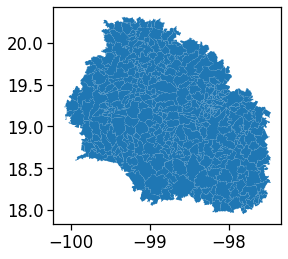

In [60]:
# Create the mapping MUN <-> original `tile_ID`
gdf_mun["tile_ID"] = np.arange(gdf_mun.shape[0], dtype=int)
mun2id = gdf_mun["tile_ID"]
agebID_to_munID = {int(zid): int(mun2id[mun])
                   for zid, mun in gdf[["tile_ID", "UNIQUE_MUN"]].values}

gdf_mun.plot()

In [61]:
len(agebID_to_munID), len(gdf)

(11428, 11428)

<AxesSubplot:>

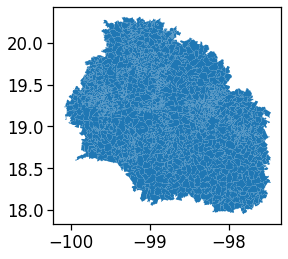

In [62]:
# Create the mapping LOC <-> original `tile_ID`
gdf_loc["tile_ID"] = np.arange(gdf_loc.shape[0], dtype=int)
loc2id = gdf_loc["tile_ID"]
agebID_to_locID = {int(zid): int(loc2id[loc])
                   for zid, loc in gdf[["tile_ID", "UNIQUE_LOC"]].values}

gdf_loc.plot()

In [63]:
len(agebID_to_locID), len(gdf)

(11428, 11428)

#### Pre-compute the distance from the epicenter

And bin these distances in discrete bins.

In [64]:
# The epicenter
epicenter_lat_lon = (18.579206,-98.399126)

In [65]:
# Compute the distance of each area's centroid from epicenter
gdf_mun["distance_epic"] = gdf_mun.geometry.centroid.apply(
                        lambda p: haversine(epicenter_lat_lon,
                                            (p.xy[1][0], p.xy[0][0]) ))
# Bin areas depending on their distance
if True:
    distance_bins_mun = np.linspace(0, max(gdf_mun["distance_epic"])+1, 6)
else:
    distance_bins_mun = np.logspace(np.log2(max(1, min(gdf_mun["distance_epic"])-1)),
                                np.log2(max(gdf_mun["distance_epic"])+1), 5, base=2)


gdf_mun["distance_bin"] = gdf_mun["distance_epic"].apply(lambda v:
                                        np.argmax(distance_bins_mun>=v)-1)

<ipython-input-65-30430ab91fef>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_mun["distance_epic"] = gdf_mun.geometry.centroid.apply(


In [66]:
gdf_mun["distance_bin"].value_counts()

1    132
2    103
3     70
0     36
4     33
Name: distance_bin, dtype: int64

<AxesSubplot:>

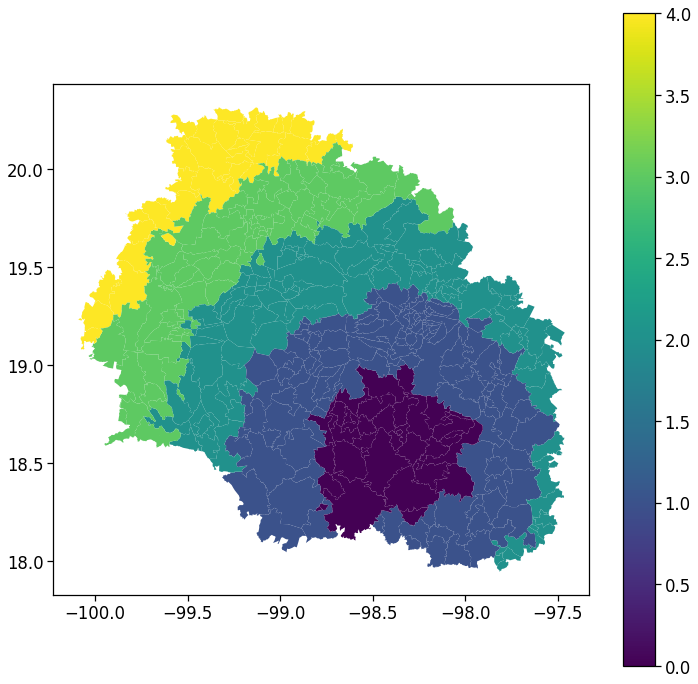

In [67]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.set_aspect("equal")

gdf_mun.plot("distance_bin", legend=True, ax=ax)

In [68]:
# The same for localities
gdf_loc["distance_epic"] = gdf_loc.geometry.centroid.apply(
                        lambda p: haversine(epicenter_lat_lon,
                                            (p.xy[1][0], p.xy[0][0]) ))
# Bin areas depending on their distance
if True:
    distance_bins_loc = np.linspace(0, max(gdf_loc["distance_epic"])+1, 6)
else:
    distance_bins_loc = np.logspace(np.log2(max(1, min(gdf_loc["distance_epic"])-1)),
                                np.log2(max(gdf_loc["distance_epic"])+1), 5, base=2)


gdf_loc["distance_bin"] = gdf_loc["distance_epic"].apply(lambda v:
                                        np.argmax(distance_bins_loc>=v)-1)

<ipython-input-68-375eb0e542a7>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_loc["distance_epic"] = gdf_loc.geometry.centroid.apply(


In [69]:
gdf_loc["distance_bin"].value_counts()

1    579
3    570
2    501
4    163
0    153
Name: distance_bin, dtype: int64

<AxesSubplot:>

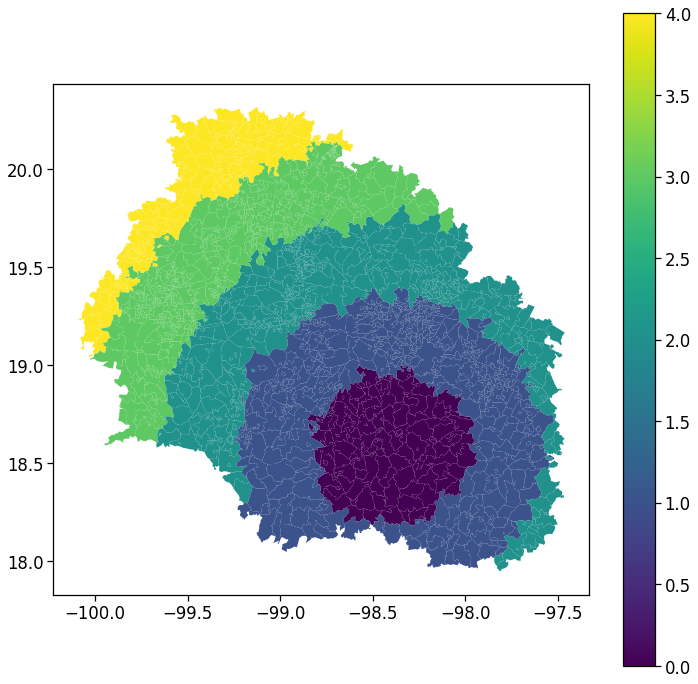

In [70]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.set_aspect("equal")

gdf_loc.plot("distance_bin", legend=True, ax=ax)

Now that we have the mappings, let us aggregate the per-AGEB displacement statistics at the municipality level.

We do that by simply aggregating and summing the number of active and displaced users living in all the AGEB of one municipality.

In [71]:
# Prepare the municipality arrays to be aggregated
n_dates = len(dates_sorted)

aggregated_displaced_mun = {}

for original, municipio in agebID_to_munID.items():
    if original not in count_users_per_area:
        # If the area has no inhabitants skip it
        continue
        
    tmp_source = count_users_per_area[original]
    try:
        tmp_target = aggregated_displaced_mun[municipio]
    except KeyError:
        aggregated_displaced_mun[municipio] = {"active": np.zeros(n_dates),
                                        "displaced": np.zeros(n_dates),}
        tmp_target = aggregated_displaced_mun[municipio]
    
    tmp_target["active"] += tmp_source["active"]
    tmp_target["displaced"] += tmp_source["displaced"]
    

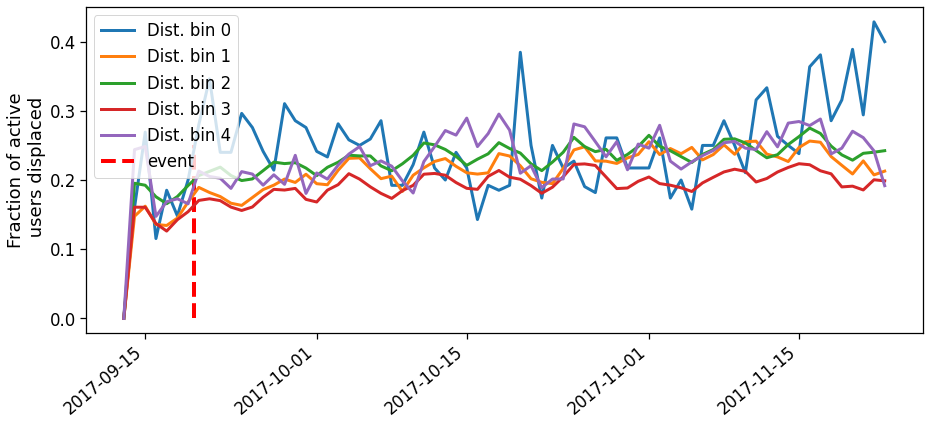

In [72]:
# Now plot the behavior of the AGEB level stats aggregated by MUN
# For each bin's areas plot the displacement rate
fig, ax = plt.subplots(1,1,figsize=(15,6))

for dist_bin in range(len(distance_bins_mun)):
    tmp_areas = set(gdf_mun[gdf_mun["distance_bin"]==dist_bin]["tile_ID"].values)
    tmp_areas = tmp_areas.intersection(aggregated_displaced_mun.keys())
    if len(tmp_areas) == 0:
        continue
        
    tmp_arra_disp = np.vstack([aggregated_displaced_mun[a]["displaced"]
                                   for a in tmp_areas])
    tmp_arra_act = np.vstack([aggregated_displaced_mun[a]["active"]
                                  for a in tmp_areas])
    plt.plot(dates_sorted, tmp_arra_disp.sum(axis=0)
             / np.clip(tmp_arra_act.sum(axis=0), a_min=1., a_max=None),
             label="Dist. bin %d"%dist_bin, lw=3)
    
plt.vlines(datetime(2017,9,19,13,14), 0, .25, lw=4, linestyles="--", color="r",
          label="event")

plt.xticks(rotation=40, ha="right")
plt.ylabel("Fraction of active\n users displaced")
plt.legend();

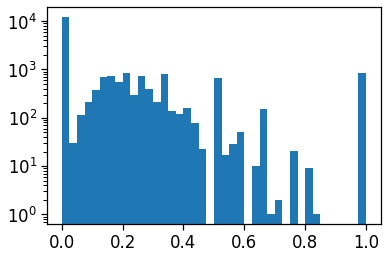

In [73]:
# See how much displacement we have (its distribution)
seen_mun_displacements = np.array([
    d / max(1,a) for area, arrays in aggregated_displaced_mun.items()
        for a, d in zip(arrays["active"], arrays["displaced"])
])

plt.hist(seen_mun_displacements, bins=40)
plt.semilogy();

In [74]:
# And now save, for each date, the map of the displacement rate
# Select the min and max displacement values to be used for every date
min_disp_map = .0
max_disp_map = .5

# Make a directory where to save frames
outDirFrames = "data/displacementMunMovie"
if not os.path.exists(outDirFrames):
    os.makedirs(outDirFrames)
    
for index, date in enumerate(dates_sorted):
    date = pd.to_datetime(date)
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    ax.set_aspect("equal")
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    gdf_mun["tmp_values"] = gdf_mun["tile_ID"].apply(lambda z:
        aggregated_displaced_mun[z]["displaced"][index]
        / max(1, aggregated_displaced_mun[z]["active"][index])
        if z in aggregated_displaced_mun else None
            )
    gdf_mun[~gdf_mun["tmp_values"].isna()].plot("tmp_values", legend=True,
                 vmin=min_disp_map, vmax=max_disp_map,
                 ax=ax, cax=cax,
                 legend_kwds={
                     'label': "Displacement by Municipality",
                             })
    
    gdf_mun[gdf_mun["tmp_values"].isna()].plot(ax=ax, color="grey")
    
    ax.set_title("Date: %s"%date.strftime("%d-%m-%Y"), size=22)
    
    if date >= datetime(2017,9,19).date():
        ax.plot(epicenter_lat_lon[1], epicenter_lat_lon[0],
               "or", ms=20, alpha=.8)
    
    plt.tight_layout()
    plt.savefig(os.path.join(outDirFrames, "frame_%04d.png"%index),
                dpi=80)

    plt.close()
    del gdf_mun["tmp_values"]
    
    sys.stdout.write("\rDate %04d / %04d done..." % (index+1, n_dates))
    sys.stdout.flush()

Date 0072 / 0072 done...

In [75]:
# Launch the command to make movie (make sure ffmpeg is installed)
!ffmpeg -y -r 1/2 -i data/displacementMunMovie/frame_%04d.png -c:v libx264 -vf fps=1 -pix_fmt yuv420p data/displacementMunMovie.mp4

ffmpeg version n4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10.2.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid --enable-nvdec --enable-nvenc --enabl

In [76]:
# And display it here
from IPython.display import Video
Video("data/displacementMunMovie.mp4", width=600)

### Now repeat the same analysis but counting the displaced from municipality or locality

Here we count the location of the users using the municipality (or locality) as the base entity.

The main problem with the AGEB analysis shown above is that we aggregate by manzanas (AGEB) that can be quite small and thus noisy.

The procedure is exactly as before, we just replace the original `tile_ID` with the corresponding municipality or locality codes.

In [77]:
# Specify the GDF and zone mapping to use
if False:
    figure_label = "localities"
    gdf_to_use = gdf_loc.copy()
    zone_mapping_to_use = agebID_to_locID.copy()
else:
    figure_label = "municipalities"
    gdf_to_use = gdf_mun.copy()
    zone_mapping_to_use = agebID_to_munID.copy()

In [79]:
df_hw_cached.replace()

,UTC,uid,OS,lat,lng,acc,tz,tile_ID,datetime,day,isHome,isWork
npartitions=1000,,,,,,,,,,,,
,int64,object,float64,float64,float64,float64,float64,int64,datetime64[ns],datetime64[ns],bool,bool
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


In [3]:
df_hw_agg = mobilkit.spatial.replaceAreaID(df_hw_cached, zone_mapping_to_use)

In [81]:
initial_days_home = 31
home_days_window = 4
start_date=None

In [82]:
agg_df_joined_pd = mobilkit.temporal.homeLocationWindow(df_hw_agg,
                    initial_days_home=initial_days_home,
                    home_days_window=home_days_window,
                    start_date=None, stop_date=None)

Doing window 01 / 04
Doing window 02 / 04
Doing window 03 / 04
Doing window 04 / 04


In [83]:
# Here, since the areas are larger, we have less noise on the location
# and we can also keep lower number of bins

minimum_pings_per_night = 3

pivoted_agg, prima_zona_agg,\
    heaps_agg, count_users_per_agg = mobilkit.temporal.computeDisplacementFigures(
        agg_df_joined_pd, minimum_pings_per_night=minimum_pings_per_night,
)


In [84]:
dates_sorted_agg = np.array(pivoted_agg.columns)

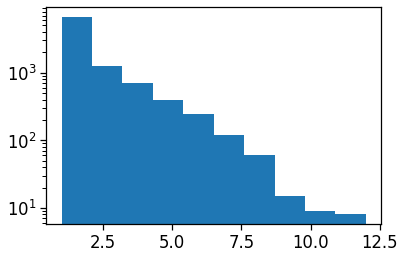

In [86]:
# Plot the number of homes distribution
case_pop = np.array([len(set([d for d in v if not np.isnan(d)]))
                         for v in pivoted_agg.values])
plt.hist(case_pop)

plt.semilogy();

In [87]:
# Around the epicenter
zone_agg_earth = mobilkit.spatial.selectAreasFromBounds(gdf_to_use,
                    min_lon=-98.682, max_lat=18.928, max_lon=-97.890, min_lat=18.158)

# Far away in Mexico City
zone_agg_mexc = mobilkit.spatial.selectAreasFromBounds(gdf_to_use,
                    min_lon=-99.404, max_lat=19.555, max_lon=-98.739, min_lat=19.188)

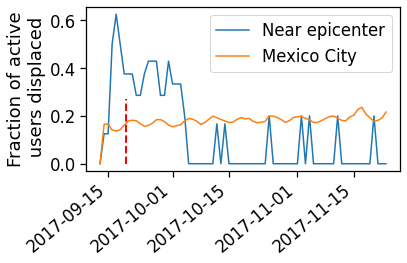

In [88]:
tmp_arra_disp = np.vstack([count_users_per_agg[a]["displaced"]
                          for a in zone_agg_earth if a in count_users_per_agg])
tmp_arra_act = np.vstack([count_users_per_agg[a]["active"]
                          for a in zone_agg_earth if a in count_users_per_agg])
plt.plot(dates_sorted, tmp_arra_disp.sum(axis=0)
         / np.clip(tmp_arra_act.sum(axis=0), a_min=1., a_max=None),
         label="Near epicenter")

tmp_arra_disp = np.vstack([count_users_per_agg[a]["displaced"]
                          for a in zone_agg_mexc if a in count_users_per_agg])
tmp_arra_act = np.vstack([count_users_per_agg[a]["active"]
                          for a in zone_agg_mexc if a in count_users_per_agg])
plt.plot(dates_sorted, tmp_arra_disp.sum(axis=0)
         / np.clip(tmp_arra_act.sum(axis=0), a_min=1., a_max=None),
        label="Mexico City")

plt.vlines(datetime(2017,9,19,13,14), 0, .27, lw=2, linestyles="--", color="r")

plt.xticks(rotation=40, ha="right")
plt.ylabel("Fraction of active\n users displaced")
plt.legend();

plt.tight_layout()
plt.savefig("figures/displacement_far_close_%s.pdf"%figure_label,
            bbox_inches="tight")

## Try to see displacement as a distance from epicenter

In [89]:
# Distance from epicenter
epicenter_lat_lon = (18.579206,-98.399126)

In [90]:
# Compute the distance of each area's centroid from epicenter
gdf_to_use["distance_epic"] = gdf_to_use.geometry.centroid.apply(
                        lambda p: haversine(epicenter_lat_lon,
                                            (p.xy[1][0], p.xy[0][0]) ))

<ipython-input-90-47b65d57788a>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_to_use["distance_epic"] = gdf_to_use.geometry.centroid.apply(


In [91]:
# Bin areas depending on their distance
if True:
    distance_bins = np.linspace(0, max(gdf_to_use["distance_epic"])+1, 6)
else:
    distance_bins = np.logspace(np.log2(max(1, min(gdf_to_use["distance_epic"])-1)),
                                np.log2(max(gdf_to_use["distance_epic"])+1), 5, base=2)


gdf_to_use["distance_bin"] = gdf_to_use["distance_epic"].apply(lambda v:
                                        np.argmax(distance_bins>=v)-1)

In [92]:
gdf_to_use["distance_bin"].value_counts()

1    132
2    103
3     70
0     36
4     33
Name: distance_bin, dtype: int64

<AxesSubplot:>

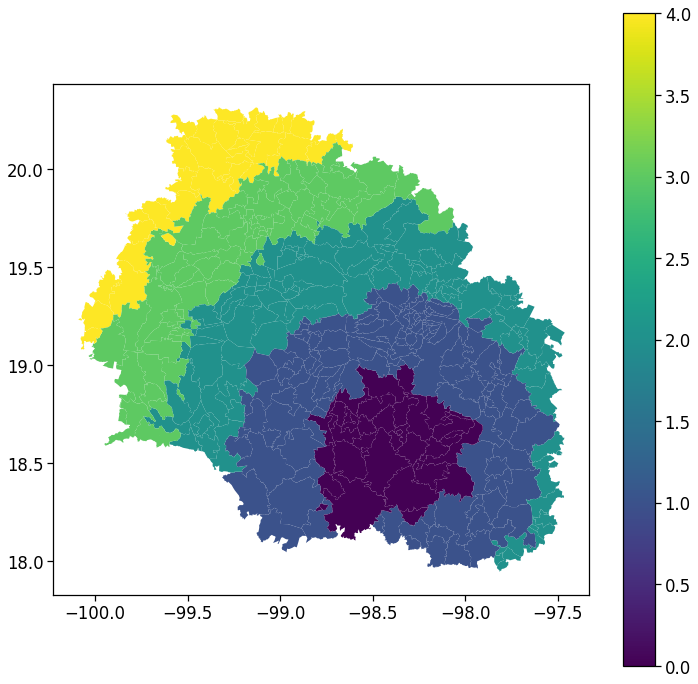

In [93]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.set_aspect("equal")

gdf_to_use.plot("distance_bin", legend=True, ax=ax)

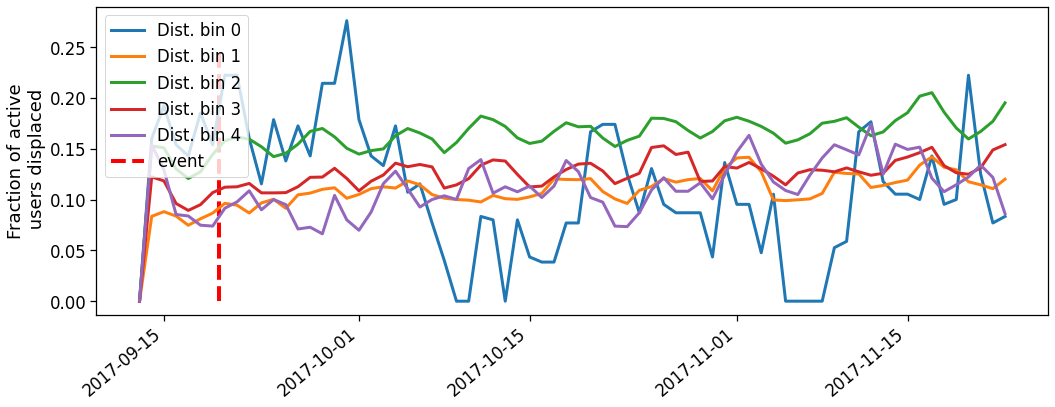

In [94]:
# For each area plot the displacement rate
fig, ax = plt.subplots(1,1,figsize=(15,6))

for dist_bin in range(len(distance_bins)):
    tmp_areas = set(gdf_to_use[
                        gdf_to_use["distance_bin"]==dist_bin]["tile_ID"].values)
    tmp_areas = tmp_areas.intersection(count_users_per_agg.keys())
    if len(tmp_areas) == 0:
        continue
        
    tmp_arra_disp = np.vstack([count_users_per_agg[a]["displaced"]
                               for a in tmp_areas])
    tmp_arra_act = np.vstack([count_users_per_agg[a]["active"]
                              for a in tmp_areas])
    plt.plot(dates_sorted_agg, tmp_arra_disp.sum(axis=0)
             / np.clip(tmp_arra_act.sum(axis=0), a_min=1., a_max=None),
             label="Dist. bin %d"%dist_bin, lw=3)

plt.vlines(datetime(2017,9,19,13,14), 0, .25, lw=4, linestyles="--", color="r",
          label="event")
    
plt.xticks(rotation=40, ha="right")
plt.ylabel("Fraction of active\n users displaced")
plt.legend();

plt.tight_layout()
plt.savefig("figures/displacement_far_close_curves_%s.pdf"%figure_label,
            bbox_inches="tight")

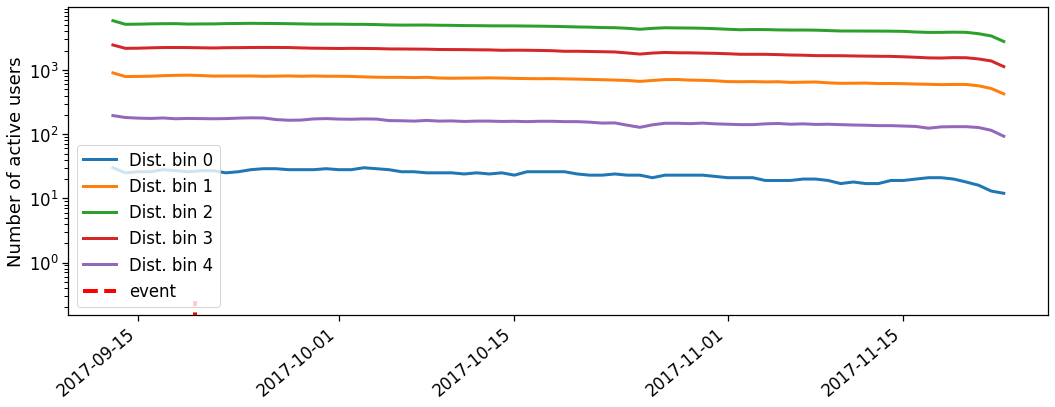

In [95]:
# For each area plot thenumber of active users in time
fig, ax = plt.subplots(1,1,figsize=(15,6))

for dist_bin in range(len(distance_bins)):
    tmp_areas = set(gdf_to_use[gdf_to_use["distance_bin"]==dist_bin]["tile_ID"].values)
    tmp_areas = tmp_areas.intersection(count_users_per_agg.keys())
    if len(tmp_areas) == 0:
        continue
        
    tmp_arra_act = np.vstack([count_users_per_agg[a]["active"] for a in tmp_areas])
    plt.semilogy(dates_sorted_agg, tmp_arra_act.sum(axis=0),
             label="Dist. bin %d"%dist_bin, lw=3)

plt.vlines(datetime(2017,9,19,13,14), 0, .25, lw=4, linestyles="--", color="r",
          label="event")
    
plt.xticks(rotation=40, ha="right")
plt.ylabel("Number of active users")
plt.legend();
plt.tight_layout()
plt.savefig("figures/displacement_far_close_curves_active_%s.pdf"%figure_label,
            bbox_inches="tight")